In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots,CSV,DataFrames;
import NLsolve,Roots;
import Optim;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [1]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end

xsqrt (generic function with 1 method)

In [4]:
#https://github.com/fkguo/IMinuit.jl/blob/master/src/Data.jl
# check whether the data are valid for a fit
function check_data(xdata, ydata, errdata)
    if any(ismissing, xdata) || any(ismissing, ydata) || any(ismissing, errdata)
        error("Error: Data contain `missing` values.")
    end
    if any(isinf, xdata) || any(isinf, ydata) || any(isnan, xdata) || any(isnan, ydata) || any(isnan, errdata)
        error("Error: Data contain `Inf` or `NaN` values.")
    end
    if any(iszero, errdata)
        error("Error: Data contain 0 in the errors.")
    end
end

"""
    Data(x::T, y::T, err::T) where {T<:Vector{Real}}
    Data(df::DataFrame)
Fields: `x, y, err, ndata`
This defines a type for data with three columns:` x, y, err`; `ndata` is the number of data rows.
Different `Data` sets can be concatenated as `vcat(dat1, dat2, dat3)`.
Only symmetric errors (of `y`) are supported.
"""
struct Data
    x::Vector{Float64}
    y::Vector{Float64}
    err::Vector{Float64}
    ndata::Int
    function Data(x, y, err) # Data(x::Vector{T}, y::Vector{T}, err::Vector{T}) where {T<:Real}
        check_data(x, y, err)
        ndata = length(x)
        new(x, y, err, ndata)
    end
end

Data(df::DataFrame) = Data(df[:,1], df[:,2], df[:,3])

import Base.vcat, Base.getindex
vcat(dat1::Data, dat2::Data) = Data(vcat(dat1.x, dat2.x), vcat(dat1.y, dat2.y), vcat(dat1.err, dat2.err))
vcat(dat1::Data, dat...) = reduce(vcat, [dat1, dat...])
getindex(data::Data, in) = Data(map(x-> getindex(x, in), (data.x, data.y, data.err))...)

"""
    @plt_data(data, kws...)
    @plt_data!(data, kws...)
Convenient mascros to make an errorbar plot of the `data`; all combinations of
keyword settings for `scatter` in `Plots` can be used for the optional arguments `kws...`
"""
macro plt_data(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end
macro plt_data!(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter!($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter!($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end


@doc raw"""
    chisq(dist::Function, data, par; fitrange = ())
defines the ``\chi^2`` function: `fun` the function to be fitted to the data given by `data`.
The parameters are collected into `par`, given as an array or a tuple.
* `data` can be either given as the `Data` type, or of the form `(xdata, ydata [, err])`.
If no `err` is given explicitly, the errors are assumed to be 1 for all data points.
* `fitrange`: default to the whole data set; may given as, e.g., `2:10`,
which means only fitting to the 2nd to the 10th data points.
"""
function chisq(dist::Function, data::Data, par; fitrange = ())
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
    end
    return res
end
# function chisq(dist::Function, data::Data, par::Tuple; fitrange = ())
#     fitrange = (isempty(fitrange) && 1:data.ndata)
#     res = 0.0
#     @simd for i = fitrange
#         @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
#     end
#     return res
# end
function chisq(dist::Function, data, par; fitrange = ())
    _x = data[1]; _y = data[2]
    _n = length(_x)
    _err = (length(data) == 2 ? ones(_n) : data[3])
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (_y[i]- dist(_x[i], par))/_err[i] )^2
    end
    return res
end

"""
    @plt_best(dist, fit, data, kws...)
    @plt_best!(dist, fit, data, kws...)
A convenient macro for comparing the best-fit result with the data; all combinations of
keyword settings for `plot` in `Plots` can be used for the optional arguments `kws...`
The ordering of `dist`, `fit`, and `data` does not matter.
"""
macro plt_best(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end
macro plt_best!(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter!($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end

function quadgauss(f, x::T, w::T) where {T<:Vector{Float64}}
    res = zero(f(x[1]))  # zero of the same type as f(x[1]), to avoid type instability
    for i in eachindex(x)
        res += f(x[i]) * w[i]
    end
    return res
end

quadgauss (generic function with 1 method)

# VGT

In [5]:
μc,μ0=μf(mDn,mDsc),μf(mDc,mDsn)

(0.9674107141493122, 0.9679003081419646)

In [6]:
qon_c(E)=xsqrt(2*μc*(E-mDn-mDsc+im*ΓDsc/2))
qon_0(E)=xsqrt(2*μ0*(E-mDc-mDsn+im*ΓDsn/2))

qon_0 (generic function with 1 method)

In [7]:
xxx,www=gauss(50,0,1);

In [8]:
qi=zeros(ComplexF64,2*length(xxx)+2);
wi=zeros(ComplexF64,length(xxx));

In [9]:
len=length(xxx);
sublen=length(qi);

In [10]:
function find_qw(E,Λ;rs=1,qi=qi,wi=wi)
    pmax=sqrt(abs(λf(E^2,mDn^2,(mπc+mDn)^2)))/(2*E)
    qi[1],qi[2]=qon_c(E)*(-1)^(rs+1),qon_0(E) 
    for i in eachindex(xxx)
        qi[2+i]=pmax*xxx[i]
        qi[i+len+2]=Λ*xxx[i]
        wi[i]=Λ*www[i]
    end
    nothing
end

find_qw (generic function with 1 method)

In [11]:
Vmat=zeros(ComplexF64,4*length(qi),4*length(qi));
Gmat=zeros(ComplexF64,4*length(qi),4*length(qi));
Tmat=zeros(ComplexF64,4*length(qi),4*length(qi));

In [12]:
function VMat!(E;rs=1,Λ=0.5,a = 0.0,a1=0.0,I=0,plist=qi,des=Vmat)
    find_qw(E,Λ;rs=rs)
    sublen=length(plist)
    k1,k2=plist[1],plist[2]

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m],k1,k1; a = a,a1=a1,I=I, cl = :ss,isπ=false))
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m],k1,k1; a = a,a1=a1,I=I, cl = :ds,isπ=false))
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m],k1,k1; a = a,a1=a1,I=I,  cl = :sd,isπ=false))
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m],k1,k1; a = a,a1=a1,I=I, cl = :dd,isπ=false))
            i, j = 1, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m],k2,k1; a = a,a1=a1,I=I,  cl = :ss,isπ=false))
            i, j = 1, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m],k2,k1; a = a,a1=a1,I=I,  cl = :ds,isπ=false))
            i, j = 2, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m],k2,k1; a = a,a1=a1,I=I,  cl = :sd,isπ=false))
            i, j = 2, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m],k2,k1; a = a,a1=a1,I=I,  cl = :dd,isπ=false))
            i, j = 3, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m],k1,k2; a = a,a1=a1,I=I,  cl = :ss,isπ=false))
            i, j = 3, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m],k1,k2; a = a,a1=a1,I=I,  cl = :ds,isπ=false))
            i, j = 4, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m],k1,k2; a = a,a1=a1,I=I,  cl = :sd,isπ=false))
            i, j = 4, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m],k1,k2; a = a,a1=a1,I=I,  cl = :dd,isπ=false))
            i, j = 3, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m],k2,k2; a = a,a1=a1,I=I,  cl = :ss,isπ=false))
            i, j = 3, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m],k2,k2; a = a,a1=a1,I=I,  cl = :ds,isπ=false))
            i, j = 4, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m],k2,k2; a = a,a1=a1,I=I,  cl = :sd,isπ=false))
            i, j = 4, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m],k2,k2; a = a,a1=a1,I=I,  cl = :dd,isπ=false))
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

In [19]:
@btime VMat!(3.875)

  49.802 ms (512 allocations: 8.88 KiB)


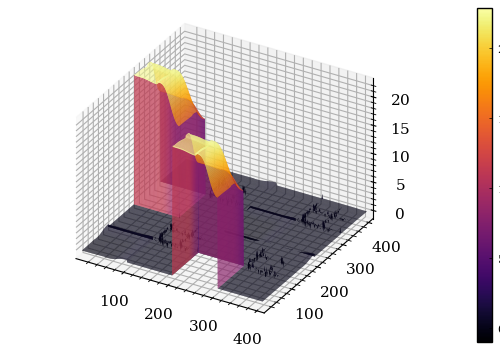

In [20]:
surface(collect(1:4*length(qi)),collect(1:4*length(qi)),[real(Vmat[x,y]) for y in 1:4*length(qi),x in 1:4*length(qi)])

In [13]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDsc/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsn/2)

Gn (generic function with 1 method)

In [14]:
function GMat!(E;rs=1,Λ=0.5,qi=qi,wi=wi,des=Gmat)
    find_qw(E,Λ;rs=rs)
    sublen=length(qi)
    μ1,μ2=μf(mDn,mDsc),μf(mDc,mDsn)
    k1,k2=qi[1],qi[2]
    
    tmp=zero(ComplexF64)
    
    for i in 1:2
        tmp=0.0+0.0im
        for j in eachindex(wi)
            des[(i-1)*sublen+2+len+j,(i-1)*sublen+2+len+j]=wi[j]*qi[2+len+j]^2*Gc(E,qi[2+len+j])
            tmp+=-wi[j]*k1^2*Gc(E,qi[2+len+j])
        end
        des[(i-1)*sublen+1,(i-1)*sublen+1]=tmp+μ1*k1/(2π^2)*(log((Λ+k1)/(Λ-k1))-im*π)
    end
    
    for i in 3:4
        tmp=0.0+0.0im
        for j in eachindex(wi)
            des[(i-1)*sublen+2+len+j,(i-1)*sublen+2+len+j]=wi[j]*qi[2+len+j]^2*Gn(E,qi[2+len+j])
            tmp+=-wi[j]*k2^2*Gn(E,qi[2+len+j])
        end
        des[(i-1)*sublen+2,(i-1)*sublen+2]=tmp+μ2*k2/(2π^2)*(log((Λ+k2)/(Λ-k2))-im*π)
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [15]:
function detVG(E;rs=1,Λ=0.5,a = 0.0,a1=0.0,I=0)
    VMat!(E;rs=rs,Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;rs=rs,Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [16]:
function TMat!(E;rs=1,Λ=0.5,a = 0.0,a1=0.0,I=0,des=Tmat)
    VMat!(E;rs=rs,Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;rs=rs,Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

In [25]:
let 
    function inv_abst(x;rs=1,E=mDn+mDsc-273e-6,I=0)
        TMat!(E;rs=rs,Λ=x[1],I=I)
        return 1/abs(Tmat[1,1])
    end
    
    tmpf(x)=inv_abst(x)
    init_val=[0.7]
    lower=[0.5]
    upper=[1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.0002949780790359497
[0.7535235592319975]


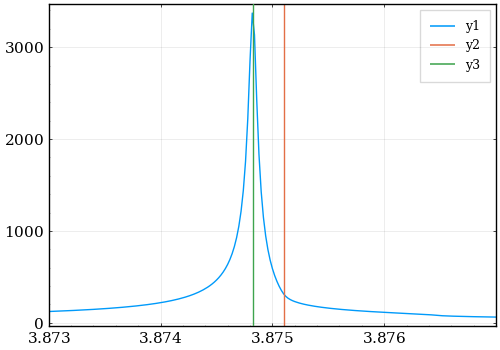

In [26]:
let Ev=collect(3.873:0.00002:3.877)
    function tmpf(E)
        TMat!(E;rs=1,Λ=0.7535235591643434)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

# observable

In [17]:
using Interpolations;

In [18]:
xxx1,www1=gauss(50,0,1);

In [19]:
function maketmatrixf(E)
    tmatrix=zeros(ComplexF64,len)
    tmp=zero(ComplexF64)
    for k in 3:(2+len)
        tmp=1.0
        for i in eachindex(wi)
            tmp+=wi[i]*qi[2+len+i]^2*Gc(E,qi[2+len+i])*Tmat[k,2+len+i]
            tmp+=-wi[i]*qi[2+len+i]^2*Gn(E,qi[2+len+i])*Tmat[k,2*sublen+2+len+i]
        end
        tmatrix[k-2]=tmp
    end
    return LinearInterpolation(real.(qi[3:2+len]),tmatrix)
end

maketmatrixf (generic function with 1 method)

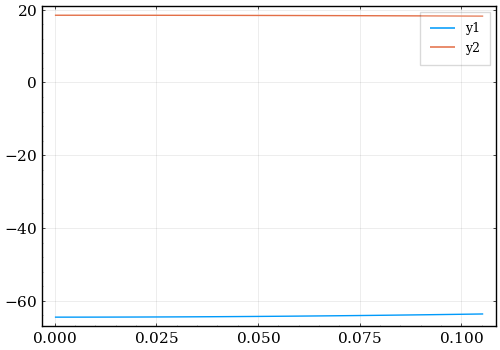

In [31]:
let 
    TMat!(3.875;rs=1,Λ=0.7535235592839636)
    tmpf=maketmatrixf(3.875)
    pv=real.(qi[3:2+len])
    plot(pv,p->real(tmpf(p)))
    plot!(pv,p->imag(tmpf(p)))
end

In [20]:
function Γ3f(E;rs=1, Λ = 0.5)
    TMat!(E; rs=rs,Λ = Λ)

    res = 0.0
    μ1, μ2 = μf(mDn, mDsc), μf(mDc, mDsn)
    m1,m2,m3=mDn,mπc,mDn

    tmptmatrixf = maketmatrixf(E)
    tmatrixf(p) = (real(qi[3]) <= p && p <= real(qi[2+len])) ? tmptmatrixf(p) : 0.0
    for i in eachindex(xxx1)
        for j in eachindex(xxx1)
            x1, x2, w1, w2 = xxx1[i], xxx1[j], www1[i], www1[j]
            s23=(m2+m3)^2*(1-x1)+(E-m1)^2*x1
            s12_min=m1^2+m2^2-(s23-E^2+m1^2)*(s23+m2^2-m3^2)/(2*s23)-sqrt(abs(λf(s23,E^2,m1^2)*λf(s23,m2^2,m3^2)))/(2*s23)
            s12_max=m1^2+m2^2-(s23-E^2+m1^2)*(s23+m2^2-m3^2)/(2*s23)+sqrt(abs(λf(s23,E^2,m1^2)*λf(s23,m2^2,m3^2)))/(2*s23)
            s12=s12_min*(1-x2)+s12_max*x2
            q,qbar=sqrt(λf(s23,mπc^2,mDn^2))/(2*sqrt(s23)),sqrt(λf(s12,mDn^2,mπc^2))/(2*sqrt(s12))
            p,pbar=sqrt(λf(E^2,mDn^2,s23))/(2*E),sqrt(λf(E^2,mDn^2,s12))/(2*E)
            res+=w1*w2*abs((E-m1)^2-(m2+m3)^2)*abs(s12_max-s12_min)*abs(q*tmatrixf(p)*Gc(E,p)+qbar*tmatrixf(pbar)*Gc(E,pbar))^2
        end
    end
    return res
end

Γ3f (generic function with 1 method)

In [21]:
function Resolution(E, E1)
    σ1 = 1.05 * 263e-6
    σ2 = 2.413 * σ1
    α = 0.778
    gaussfunc(x, μ, σ) = 1 / sqrt(2 * π) / σ * exp(-(x - μ)^2 / (2 * σ^2))
    return α * gaussfunc(E, E1, σ1) + (1 - α) * gaussfunc(E, E1, σ2)
end

Resolution (generic function with 1 method)

# fitting

In [51]:
using PyCall;
import NLsolve;
piminuit=pyimport("iminuit");

In [35]:
let 
    data_ddπ_sub_df = DataFrame(CSV.File("./data/ddpi_sub_du.csv", header = ["x", "y"]));
    len=length(data_ddπ_sub_df.x)
    len1=Int64(len/3)
    xv=[3.8731+0.0002*(i-1) for i in 1:20]
    yv=[data_ddπ_sub_df.y[3*(i-1)+2] for i in 1:len1]
    wv=[abs(data_ddπ_sub_df.y[3*(i-1)+1]-data_ddπ_sub_df.y[3*(i-1)+3])/2 for i in 1:len1]
    global const data_ddπ_sub=Data(xv,yv,wv);
    nothing
end

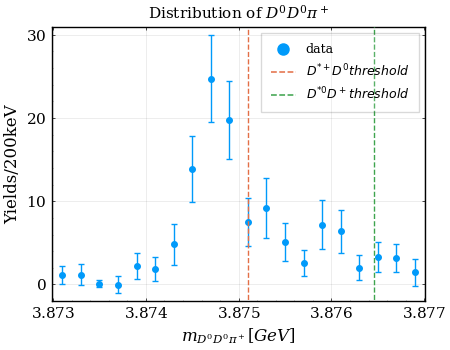

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.6056031611752245, 0.9786801175696073, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [36]:
@plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = "Yields/200keV" label = "data" size = (450, 350)
vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")

In [37]:
mutable struct distr
    rs::Int64
    Λ::Float64
    Γ3::Vector{Float64}
end

In [38]:
let Λ = 0.7535235592319975,rs=1,Ev = range(3.873, 3.877, 100)
    resv = [Γ3f(e; rs=rs,Λ = Λ) for e in Ev]
    global distr_inst = distr(rs,Λ, resv)
end

distr(1, 0.7535235592319975, [0.01144469040679531, 0.012430177106399074, 0.013511228012532166, 0.014698813176080721, 0.016005412092905427, 0.017445260452776543, 0.019034644220781473, 0.02079225144424965, 0.022739595021277068, 0.02490152293004908  …  1.8457488992771234, 1.2371789511144604, 1.8535328658881964, 2.3394080996389994, 1.8538732301689296, 1.5728482866945706, 1.6306794897479024, 1.7018750228913975, 2.015990196243297, 2.8548324297392025])

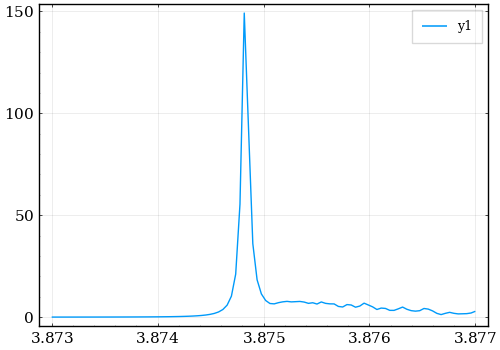

In [39]:
plot(range(3.873, 3.877, 100),distr_inst.Γ3)

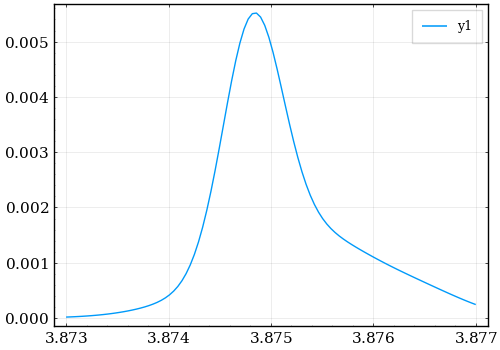

In [40]:
let
    Ev = range(3.873, 3.877, 100)
    Emin, Emax = Ev[1], Ev[end]
    tmpΓ3f = LinearInterpolation(Ev, distr_inst.Γ3)
    
    tmpf(E) = quadgauss(x ->(Emax - Emin) * tmpΓ3f(Emin + (Emax - Emin) * x) * Resolution(Emin + (Emax - Emin) * x, E), xxx1, www1)

    ΔE=0.0002
    Ebin(E,x)=(E-ΔE/2)*(1-x)+(E+ΔE/2)*x 
    tmpf1(E)=quadgauss(x->ΔE*tmpf(Ebin(E,x)),xxx1,www1)
    plot(Ev,tmpf1.(Ev))
end

In [41]:
function remake_distr(dis::distr,rs, Λ)
    if Λ ≈ dis.Λ && rs == dis.rs
        return false
    else
        Ev = range(3.873, 3.877, 100)
        for i in eachindex(dis.Γ3)
            dis.Γ3[i] = Γ3f(Ev[i];rs=rs, Λ = Λ)
        end
        dis.rs = rs
        dis.Λ = Λ
    end
    return true
end

remake_distr (generic function with 1 method)

In [42]:
function dist(E, pars; dis = distr_inst, xx = xxx1, ww = www1)
    N, rs, Λ = pars
    remake_distr(dis,rs, Λ)
    Ev = range(3.873, 3.877, 100)
    Emin, Emax = Ev[1], Ev[end]
    tmpΓ3f = LinearInterpolation(Ev, dis.Γ3)
    
    tmpf(E) = quadgauss(x ->(Emax - Emin) * tmpΓ3f(Emin + (Emax - Emin) * x) * Resolution(Emin + (Emax - Emin) * x, E), xx, ww)

    ΔE=0.0002
    Ebin(E,x)=(E-ΔE/2)*(1-x)+(E+ΔE/2)*x
    return N * quadgauss(x->ΔE*tmpf(Ebin(E,x)),xx,ww)
end

dist (generic function with 1 method)

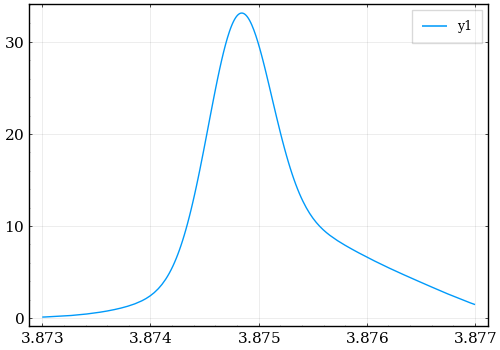

In [46]:
plot(e->dist(e,[1,1,0.7535235592319975])*30/0.005,3.873,3.877)

In [45]:
fcn(x,y,z; fitrange = ()) = chisq(dist, data_ddπ_sub,[x,y,z]; fitrange = fitrange)

fcn (generic function with 1 method)

In [52]:
function find_poles(pars)
    _rs,_lam=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ; Λ = _lam,rs = _rs)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsc - 333e-6, 0.0])
end

find_poles (generic function with 1 method)

## RSI

In [47]:
let 
    _n,_rs,_lam=[1,1,0.7535235592319975]
    tmp_model=piminuit.Minuit(fcn,N=_n,rs=_rs,lam=_lam,name=("N", "rs","lam"))
    set!(tmp_model.limits,"N",(1000,10000))
    set!(tmp_model.fixed,"rs",true)
    set!(tmp_model.limits,"lam",(0.5,1.0))
    fitres=piminuit.Minuit.migrad(tmp_model) 
    print(fitres.values)
end

PyObject <ValueView N=3518.258865235335 rs=1.0 lam=0.7569226851155093>

In [49]:
fcn(3518.258865235335,1,0.7569226851155093)

16.16454286200974

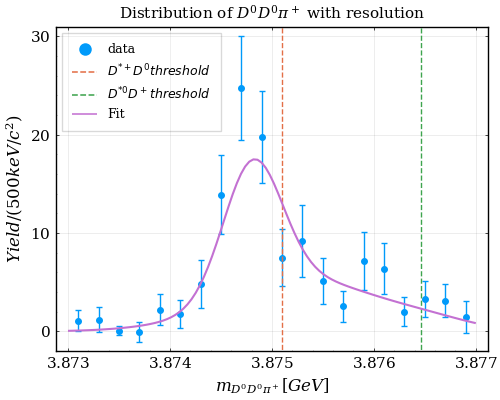

In [50]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [3518.258865235335,1,0.7569226851155093]), lw = 1.5, label = "Fit")
end

In [53]:
find_poles([1,0.7569226851155093])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, 0.0]
 * Zero: [3.8747961559913877, -3.712812086581488e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [2]:
3.8747961559913877-mDn-mDsc

-0.00030384400861249716

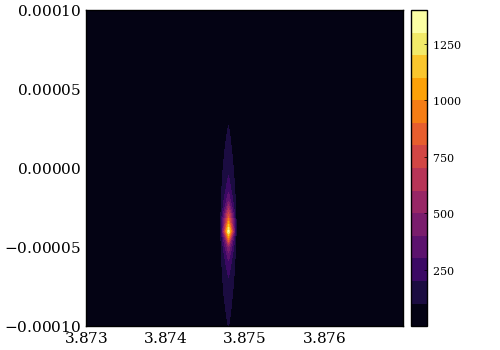

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [56]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;rs=1,Λ=0.7569226851155093)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

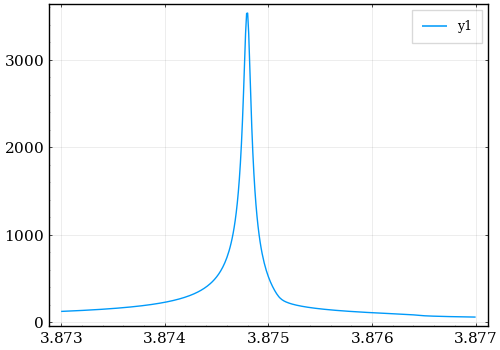

In [58]:
let 
    function tmpf(e)
        TMat!(e;rs=1,Λ=0.7569226851155093)
        abs(Tmat[1,1])
    end
    plot(3.873:0.00001:3.877,e->tmpf(e))
end

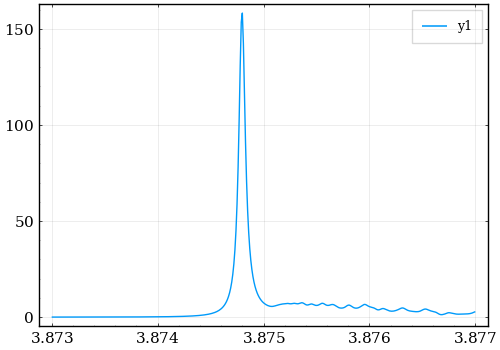

In [59]:
plot(3.873:0.00001:3.877,e->Γ3f(e;rs=1,Λ=0.7569226851155093))

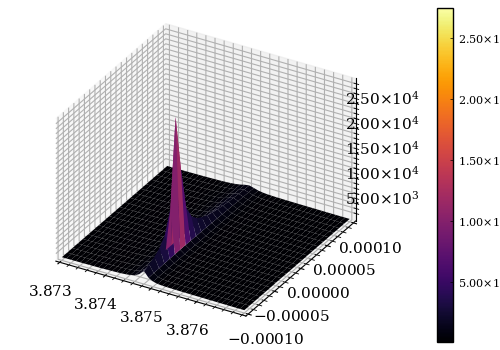

In [22]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    function tmpf(E)
        TMat!(E;Λ=0.7569226851155093)
        abs(Tmat[1,1])
    end
    resv=[real(tmpf(e+im*γ)) for γ in Γv,e in Ev]
    surface(Ev,Γv,resv)
end

## RSII

In [63]:
let 
    _n,_rs,_lam=[1,2,0.6605800044197688]
    tmp_model=piminuit.Minuit(fcn,N=_n,rs=_rs,lam=_lam,name=("N", "rs","lam"))
    set!(tmp_model.limits,"N",(1000,10000))
    set!(tmp_model.fixed,"rs",true)
    set!(tmp_model.limits,"lam",(0.5,1.0))
    fitres=piminuit.Minuit.migrad(tmp_model) 
    print(fitres.values)
end

PyObject <ValueView N=1773.2628341628247 rs=2.0 lam=0.6595766454504106>

In [64]:
fcn(1773.2628341628247,2,0.6595766454504106)

16.230053953558755

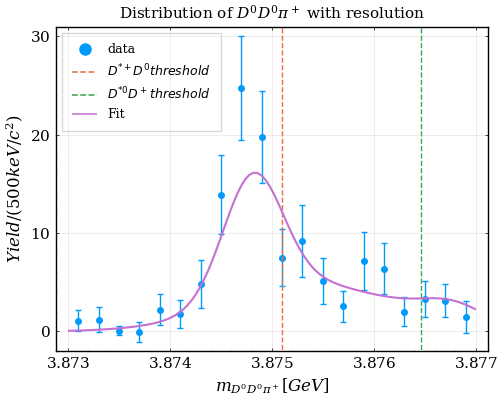

In [65]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [1773.2628341628247,2,0.6595766454504106]), lw = 1.5, label = "Fit")
end

In [66]:
find_poles([2,0.6595766454504106])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, 0.0]
 * Zero: [3.8748058761126214, -4.9611681424573685e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [67]:
3.8748058761126214-mDn-mDsc

-0.00029412388737881656

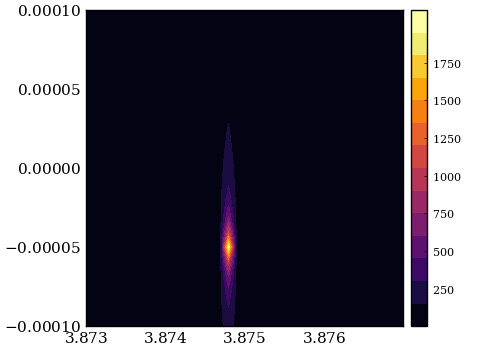

In [68]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;rs=2,Λ=0.6595766454504106)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

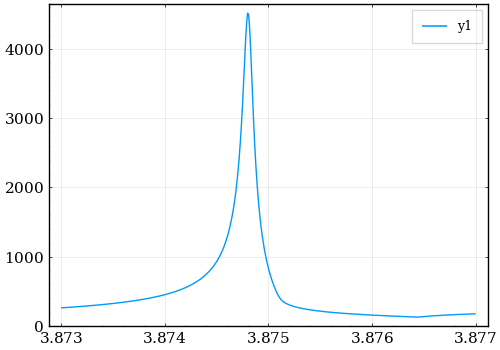

In [69]:
let 
    function tmpf(e)
        TMat!(e;rs=2,Λ=0.6595766454504106)
        abs(Tmat[1,1])
    end
    plot(3.873:0.00001:3.877,e->tmpf(e))
end

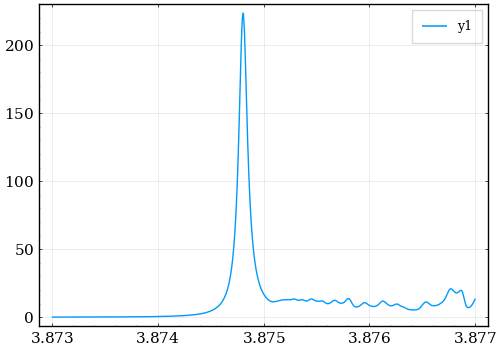

In [70]:
plot(3.873:0.00001:3.877,e->Γ3f(e;rs=2,Λ=0.6595766454504106))